# _Variational quantum simulations of stochastic differential equations_

Original authors of the paper: Kenji Kubo, Yuya O. Nakagawa, Suguru Endo, and Shota Nagayama

Link to paper: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.052425

Authors of this notebook: Óscar Amaro

__Intro__: In this notebook we reproduce the Geometric Brownian motion and Ornstein-Uhlenbeck processes, using variational quantum simulation. 
Data was retrieved from the original plots using the tool WebPlotDigitizer https://apps.automeris.io/wpd/


__Theory__:

`Geometric Brownian motion (GBM):` https://en.wikipedia.org/wiki/Geometric_Brownian_motion

> Stochastic equation: $dS_t = \mu~dS_t + \sigma~S_t~dW_t$\
> Solution: $S_t = S_0 \exp((\mu-\sigma^2/2)t-\sigma~W_t)$\
> Mean value: $\mathrm{E}(S_t) = S_0 \exp(\mu t)$\
> Variance: $\mathrm{Var}(S_t) = S_0^2~\exp(2\mu t)(\exp(\sigma^2 t)-1)$\
> Probability density: $f(t,x) = 1/(\sqrt{2\pi}~x~
\sigma~\sqrt{t}) ~\exp\left(-(\log(x)-\log(x_0)-(r-0.5~\sigma^2)t)^2/(2\sigma^2 t)\right)$\
> Parameters in paper: $r = 0.1, \sigma = 0.2$
> See "theory" in figure 5 (a), (c), (e)

`Ornstein–Uhlenbeck process (OUP):` https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process , https://web.math.ku.dk/~susanne/StatDiff/Overheads1b

The Ornstein–Uhlenbeck process can be written in terms of a probability density function, P(x,t), which satisfies a Fokker–Planck equation.

> Stochastic equation: $dx_t = -\theta~x_t~dt + \sigma~dW_t$\
> Mean value: $x_0 e^{-\theta t} + \mu(1-e^{-\theta t})$\
> Variance: $\mathrm{Var} = 0.5\sigma^2/\eta (1-\exp(-2\eta t))$\
> Fokker-Planck: $\partial_t P = \theta~\partial_x (xP) + D~\partial_{xx} P$ with $D = \sigma^2/2$\
> Transition probability/Green function: $P(x,t| x',t') = \sqrt{\dfrac{\theta}{2\pi~D~(1-e^{-2\theta(t-t')})}} \exp\left( -\dfrac{\theta}{2D}~\dfrac{(x-x' e^{-\theta(t-t')})^2}{1-e^{-2\theta(t-t')}} \right)$\
> Parameters in paper: $r = 7, \sigma = 0.5, \eta = 0.01$\
> See "theory" in figure 5 (b), (d), (f)

In [1]:
import numpy as np
from numpy import log, log10, sin, cos, exp, sqrt, pi
import pandas as pd
import glob as glob

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm

import json

# warnings
import warnings
warnings.simplefilter('ignore')

def arraycenter(x):
    """
        returns centered array for histograms
    """
    return np.array([(x[i]+x[i+1])/2 for i in range(len(x)-1)])

### Geometric Brownian motion

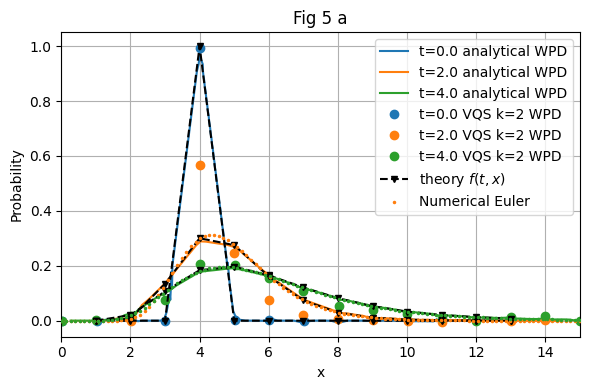

In [2]:
# fluctuations in the data will be due to uncertainty in selecting points in WPD
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 5a
f = open('dataWPD/Fig5a/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:blue', label='t=0.0 analytical WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:orange', label='t=2.0 analytical WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:green', label='t=4.0 analytical WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='tab:blue', label='t=0.0 VQS k=2 WPD')
# 
datatmp = data['datasetColl'][4]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='tab:orange', label='t=2.0 VQS k=2 WPD')
# 
datatmp = data['datasetColl'][5]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='tab:green', label='t=4.0 VQS k=2 WPD')

# theoretical solution
S0 = 4; r = 0.1; sigma = 0.2;
x = np.arange(1,14,1)
# t=0 ~Dirac delta, so normalization is a bit different
t = 1e-3
f = 1/sqrt(2*pi)/(x*sigma*sqrt(t))*exp(-(log(x)-log(S0)-(r-0.5*sigma**2)*t)**2/(2*sigma**2*t))
plt.plot(x, f/np.max(f), 'kv--', markersize=4, zorder=999, label=r'theory $f(t,x)$') 
# for finite time, normalization of f is through integral (even though resolution is low
t = 2
f = 1/sqrt(2*pi)/(x*sigma*sqrt(t))*exp(-(log(x)-log(S0)-(r-0.5*sigma**2)*t)**2/(2*sigma**2*t))
plt.plot(x, f/np.trapz(f,x), 'kv--', markersize=4, zorder=999)
t = 4
f = 1/sqrt(2*pi)/(x*sigma*sqrt(t))*exp(-(log(x)-log(S0)-(r-0.5*sigma**2)*t)**2/(2*sigma**2*t))
plt.plot(x, f/np.trapz(f,x), 'kv--', markersize=4, zorder=999)

# numerical integration Euler
def Lmatrix17_GBM(r, sigma, nqubits = 4):
    """
        L operator: matrix form in equation 17
    """
    xdim = int(2**nqubits)
    dx = 17/xdim
    
    def muk(xk): return r*xk
    def sigmak(xk): return sigma*xk

    matL = np.zeros((xdim,xdim))
    # fill matrix
    for i in range(xdim):
        xk = i * dx
        if i==0:
            matL[i,i+1] = 0.5*(sigmak(xk)**2/dx**2-muk(xk)/dx) # i=k-1
            matL[i,i] = -(matL[i,i+1]) # i=k
            
        elif i==xdim-1:
            matL[i,i-1] = 0.5*(sigmak(xk)**2/dx**2+muk(xk)/dx) # i=k+1
            matL[i,i] = -(matL[i,i-1]) # i=k
            
        else:
            matL[i,i+1] = 0.5*(sigmak(xk)**2/dx**2-muk(xk)/dx) # i=k-1
            matL[i,i-1] = 0.5*(sigmak(xk)**2/dx**2+muk(xk)/dx) # i=k+1
            matL[i,i] = -(matL[i,i-1]+matL[i,i+1]) # i=k -sigmak(xk)**2/dx**2
    return matL
# grid resolution
nqubits = 7 # should be >4 for good resolution
xc = np.linspace(0,17,2**nqubits) # grid
fsig = 1e-2; # initial spread (in theory should be exactly 0)
f = xc*0 + 1/sqrt(2*pi*fsig**2) * exp(-(xc-4)**2/(2*fsig**2)); # initial distribution function f[np.argmax(-np.abs(x-4))] = 1; #plt.plot(x,f)
tmax = 4; tdim = 10000; dt = tmax/tdim # temporal resolution
ft = np.zeros((tdim, len(xc))) # save all snapshots of f
ft[0,:] = f
L = Lmatrix17_GBM(-r, sigma, nqubits) * dt
for i in range(1,tdim):
    ft[i,:] = ft[i-1,:] + np.matmul(ft[i-1,:],L)
    ft[i, ft[i,:]<0 ] = 0
# plot Numerical Euler
y = ft[int(tdim/2),:]; plt.plot(xc, y/np.trapz(y, xc), '.', markersize=3, color='tab:orange', zorder=9999, label='Numerical Euler')
y = ft[-1,:]; plt.plot(xc, y/np.trapz(y, xc), '.', markersize=3, color='tab:green', zorder=9999)
favg = np.zeros(tdim); fvar = np.zeros(tdim)
# compute momenta
for i in range(tdim):
    favg[i] = np.trapz(ft[i,:]*xc, xc)/np.trapz(ft[i,:], xc)
    fvar[i] = np.trapz( ft[i,:]* (xc-favg[i])**2, xc )/np.trapz(ft[i,:], xc)
    
plt.xlim([0,15])
plt.title(r'Fig 5 a')
plt.xlabel(r'x')
plt.ylabel(r'Probability')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig5a_dataWPD.pdf', transparent=True)
plt.show()

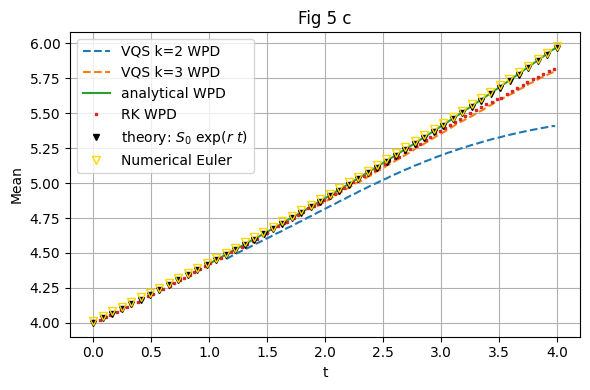

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 5c
f = open('dataWPD/Fig5c/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:blue', label='VQS k=2 WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:orange', label='VQS k=3 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:green', label='analytical WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'s', markersize=2, color='tab:red', label='RK WPD')

# theoretical solution
S0 = 4; r = 0.1; sigma = 0.2;
t = np.linspace(0,4)
plt.plot(t, S0*exp(r*t), 'kv', markersize=4, label=r'theory: $S_0~\exp(r~t)$')

# numerical integration of L
plt.plot(np.linspace(0,4,tdim)[0:-1:int(tdim/49)], favg[0:-1:int(tdim/49)], 'v', markersize=6, markerfacecolor='none',  markeredgecolor='gold', zorder=9999, label='Numerical Euler')

plt.title(r'Fig 5 c')
plt.xlabel(r't')
plt.ylabel(r'Mean')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig5c_dataWPD.pdf', transparent=True)
plt.show()

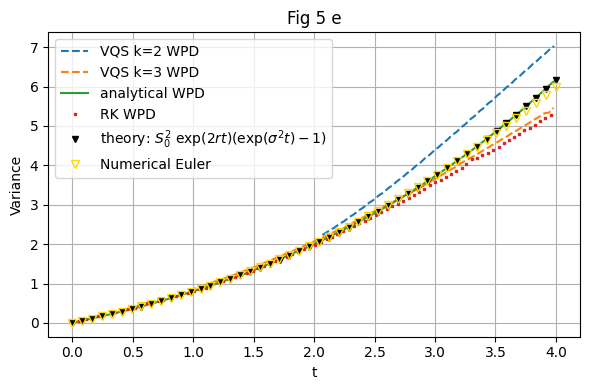

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 5e
f = open('dataWPD/Fig5e/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:blue', label='VQS k=2 WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:orange', label='VQS k=3 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:green', label='analytical WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'s', markersize=2, color='tab:red', label='RK WPD')

# theoretical solution
S0 = 4; r = 0.1; sigma = 0.2;
t = np.linspace(0,4)
plt.plot(t, S0**2 * exp(2*r*t)*(exp(sigma**2*t)-1), 'kv', markersize=4, label=r'theory: $S_0^2~\exp(2rt)(\exp(\sigma^2 t)-1)$')

# numerical integration of L
plt.plot(np.linspace(0,4,tdim)[0:-1:int(tdim/49)], fvar[0:-1:int(tdim/49)], 'v', markersize=6, markerfacecolor='none',  markeredgecolor='gold', zorder=9999, label='Numerical Euler')

plt.title(r'Fig 5 e')
plt.xlabel(r't')
plt.ylabel(r'Variance')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig5e_dataWPD.pdf', transparent=True)
plt.show()

### Ornstein-Uhlenbeck process

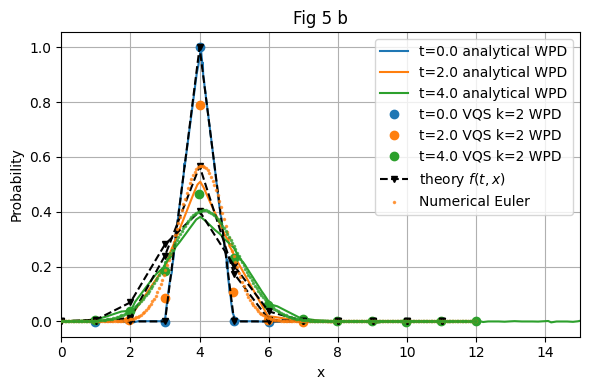

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 5b
f = open('dataWPD/Fig5b/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:blue', label='t=0.0 analytical WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:orange', label='t=2.0 analytical WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:green', label='t=4.0 analytical WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='tab:blue', label='t=0.0 VQS k=2 WPD')
# 
datatmp = data['datasetColl'][4]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='tab:orange', label='t=2.0 VQS k=2 WPD')
# 
datatmp = data['datasetColl'][5]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='tab:green', label='t=4.0 VQS k=2 WPD')


# theoretical solution
S0 = 4; r = 7; sigma = 0.5; eta=0.01; D = sigma**2/2;
x = np.arange(0,12,1)
# t=0 ~Dirac delta, so normalization is a bit different
t = 1e-3
f = sqrt(eta/(2*pi*D*(1-exp(-2*eta*t)))) * exp( -eta/(2*D) * (x - S0*exp(-eta*t))**2 / (1-exp(-2*eta*t)) )
plt.plot(x, f/np.max(f), 'kv--', markersize=4, zorder=999, label=r'theory $f(t,x)$', alpha=1) 
# for finite time, normalization of f is through integral (even though resolution is low
t = 2
f = sqrt(eta/(2*pi*D*(1-exp(-2*eta*t)))) * exp( -eta/(2*D) * (x - S0*exp(-eta*t))**2 / (1-exp(-2*eta*t)) )
plt.plot(x, f/np.trapz(f,x), 'kv--', markersize=4, zorder=999, alpha=1)
t = 4
f = sqrt(eta/(2*pi*D*(1-exp(-2*eta*t)))) * exp( -eta/(2*D) * (x - S0*exp(-eta*t))**2 / (1-exp(-2*eta*t)) )
plt.plot(x, f/np.trapz(f,x), 'kv--', markersize=4, zorder=999, alpha=1)


# numerical integration Euler
def Lmatrix17_OUP(r, sigma, eta, nqubits = 4):
    """
        L operator: matrix form in equation 17
    """
    xdim = int(2**nqubits)
    dx = 12/xdim
    
    def muk(xk): return eta*(xk-r)
    def sigmak(xk): return sigma

    matL = np.zeros((xdim,xdim))
    # fill matrix
    for i in range(xdim):
        xk = i * dx
        if i==0:
            matL[i,i+1] = 0.5*(sigmak(xk)**2/dx**2-muk(xk)/dx) # i=k-1
            matL[i,i] = -(matL[i,i+1]) # i=k
            
        elif i==xdim-1:
            matL[i,i-1] = 0.5*(sigmak(xk)**2/dx**2+muk(xk)/dx) # i=k+1
            matL[i,i] = -(matL[i,i-1]) # i=k
            
        else:
            matL[i,i+1] = 0.5*(sigmak(xk)**2/dx**2-muk(xk)/dx) # i=k-1
            matL[i,i-1] = 0.5*(sigmak(xk)**2/dx**2+muk(xk)/dx) # i=k+1
            matL[i,i] = -(matL[i,i-1]+matL[i,i+1]) # i=k -sigmak(xk)**2/dx**2
    return matL
# grid resolution
nqubits = 8 # should be >4 for good resolution
xc = np.linspace(0,12,2**nqubits) # grid
fsig = 1e-2; # initial spread (in theory should be exactly 0)
f = xc*0 + 1/sqrt(2*pi*fsig**2) * exp(-(xc-4)**2/(2*fsig**2));
tmax = 4; tdim = 10000; dt = tmax/tdim # temporal resolution
ft = np.zeros((tdim, len(xc))) # save all snapshots of f
ft[0,:] = f
L = Lmatrix17_OUP(r, sigma, eta, nqubits) * dt
for i in range(1,tdim):
    ft[i,:] = ft[i-1,:] + np.matmul(ft[i-1,:],L)
    ft[i, ft[i,:]<0 ] = 0
# plot Numerical Euler
y = ft[int(tdim/2),:]; plt.plot(xc, y/np.trapz(y, xc), '.', markersize=3, color='tab:orange', zorder=9999, label='Numerical Euler', alpha=0.7)
y = ft[-1,:]; plt.plot(xc, y/np.trapz(y, xc), '.', markersize=3, color='tab:green', zorder=9999, alpha=0.7)
favg = np.zeros(tdim); fvar = np.zeros(tdim)
# compute momenta
for i in range(tdim):
    favg[i] = np.trapz(ft[i,:]*xc, xc)/np.trapz(ft[i,:], xc)
    fvar[i] = np.trapz( ft[i,:]* (xc-favg[i])**2, xc )/np.trapz(ft[i,:], xc)

plt.xlim([0,15])
plt.title(r'Fig 5 b')
plt.xlabel(r'x')
plt.ylabel(r'Probability')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig5b_dataWPD.pdf', transparent=True)
plt.show()

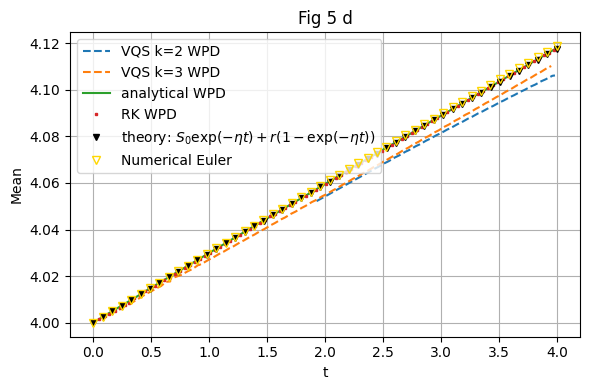

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 5d
f = open('dataWPD/Fig5d/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:blue', label='VQS k=2 WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:orange', label='VQS k=3 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:green', label='analytical WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'s', markersize=2, color='tab:red', label='RK WPD')

# theoretical solution
S0 = 4; r = 7; sigma = 0.5; eta=0.01;
t = np.linspace(0,4)
plt.plot(t, S0*exp(-eta*t) + r*(1-exp(-eta*t)), 'kv', markersize=4, label=r'theory: $S_0\exp(-\eta t) + r(1-\exp(-\eta t))$')

# numerical integration of L
plt.plot(np.linspace(0,4,tdim)[0:-1:int(tdim/49)], favg[0:-1:int(tdim/49)], 'v', markersize=6, markerfacecolor='none',  markeredgecolor='gold', zorder=9999, label='Numerical Euler')

plt.title(r'Fig 5 d')
plt.xlabel(r't')
plt.ylabel(r'Mean')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
#plt.savefig('fig5d_dataWPD.pdf', transparent=True)
plt.show()

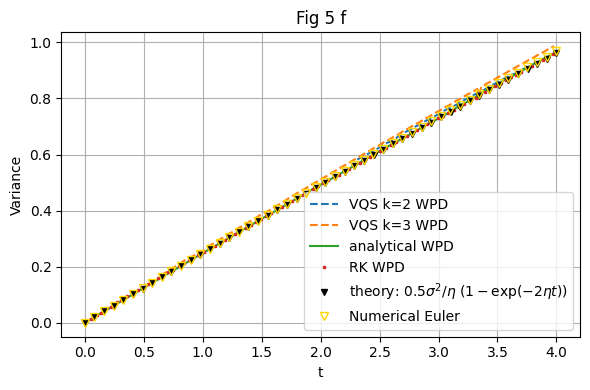

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

### fig 5f
f = open('dataWPD/Fig5f/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:blue', label='VQS k=2 WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'--', color='tab:orange', label='VQS k=3 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'-', color='tab:green', label='analytical WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'s', markersize=2, color='tab:red', label='RK WPD')

# theoretical solution
S0 = 4; r = 7; sigma = 0.5; eta=0.01;
t = np.linspace(0,4)
plt.plot(t, 0.5*sigma**2/eta * (1-exp(-2*eta*t)), 'kv', markersize=4, label=r'theory: $0.5\sigma^2/\eta~(1-\exp(-2\eta t))$')

# numerical integration of L
plt.plot(np.linspace(0,4,tdim)[0:-1:int(tdim/49)], fvar[0:-1:int(tdim/49)], 'v', markersize=6, markerfacecolor='none',  markeredgecolor='gold', zorder=9999, label='Numerical Euler')

plt.title(r'Fig 5 f')
plt.xlabel(r't')
plt.ylabel(r'Variance')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig5f_dataWPD.pdf', transparent=True)
plt.show()